---

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

import sys
sys.path.append("/home/twhit/smc_object_detection/")
from utils.misc import select_cuda_device

device = select_cuda_device()

Selected device 2, which has 11001 MB available.


### Load in ground truth

In [2]:
images = torch.load("../data/images.pt").to(device)
unpruned_counts = torch.load("../data/unpruned_counts.pt").to(device)
pruned_counts = torch.load("../data/pruned_counts.pt").to(device)
unpruned_fluxes = torch.load("../data/unpruned_fluxes.pt").to(device)
pruned_fluxes = torch.load("../data/pruned_fluxes.pt").to(device)

### Load in SMC results from repeated runs

In [3]:
num_images = images.shape[0]
num_catalogs_per_count = [1000, 3000, 5000]
num_mh_iters = [25, 50, 100]
num_runs = 100
max_objects = 10

In [4]:
runtime = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs)
num_iters = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs)
log_norm_const = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs, max_objects + 1)
total_intrinsic_flux = torch.zeros(num_images, len(num_catalogs_per_count), len(num_mh_iters), num_runs)

for i in range(num_images):
    for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
            runtime[i,c,m] = torch.load(f'smc/runtime_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt')
            num_iters[i,c,m] = torch.load(f'smc/num_iters_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt')
            log_norm_const[i,c,m] = torch.load(f'smc/log_norm_const_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt')
            total_intrinsic_flux[i,c,m] = torch.load(f'smc/total_intrinsic_flux_image{i+1}_cats{num_catalogs_per_count[c]}_mh{num_mh_iters[m]}.pt').mean(-1)

### Plot attributes

In [5]:
smc_color = "steelblue"

bigfont = 20
mediumfont = 16
smallfont = 14

mh_colors = ['olivedrab', 'darkorange', 'rebeccapurple']
mh_markers = ['s', 'o', 'D']

---

### Figure 2: Variance of marginal likelihood estimates

In [6]:
log_norm_const_estimate = log_norm_const.median(-2).values
log_norm_const_lower = log_norm_const.quantile(0.05, dim = -2)
log_norm_const_upper = log_norm_const.quantile(0.95, dim = -2)

### Estimated marginal loglikelihood for the image with three sources

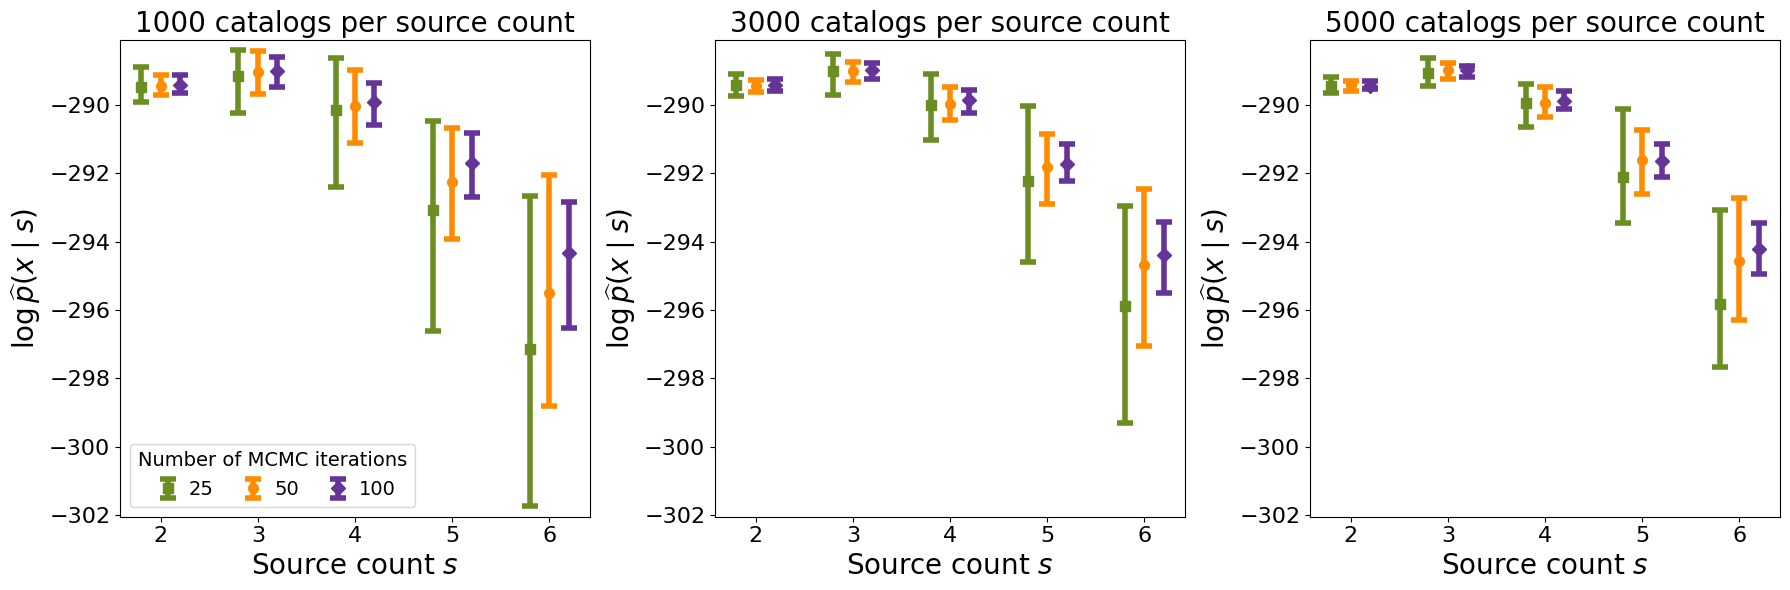

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 0

count_index = log_norm_const_estimate[i,-1,-1].sort().indices[-5:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = log_norm_const_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                   y = median,
                                   yerr = [median - log_norm_const_lower[i,c,m][count_index].numpy(),
                                           log_norm_const_upper[i,c,m][count_index].numpy() - median],
                                   linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                   ms = 7, elinewidth = 4, capsize = 6, capthick = 4)
                _ = ax[c].set_ylim(1.001 * log_norm_const_lower[i,...,count_index].min(),
                                   0.999 * log_norm_const_upper[i,...,count_index].max())
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\log \\widehat{p}(x \mid s)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations",
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

fig.savefig('figures/figure2a.png', dpi = 250, transparent = True)

---

### Posterior count probabilities for the image with three sources

In [8]:
countprob_estimate = log_norm_const.softmax(-1).median(-2).values
countprob_lower = log_norm_const.softmax(-1).quantile(0.05, dim = -2)
countprob_upper = log_norm_const.softmax(-1).quantile(0.95, dim = -2)

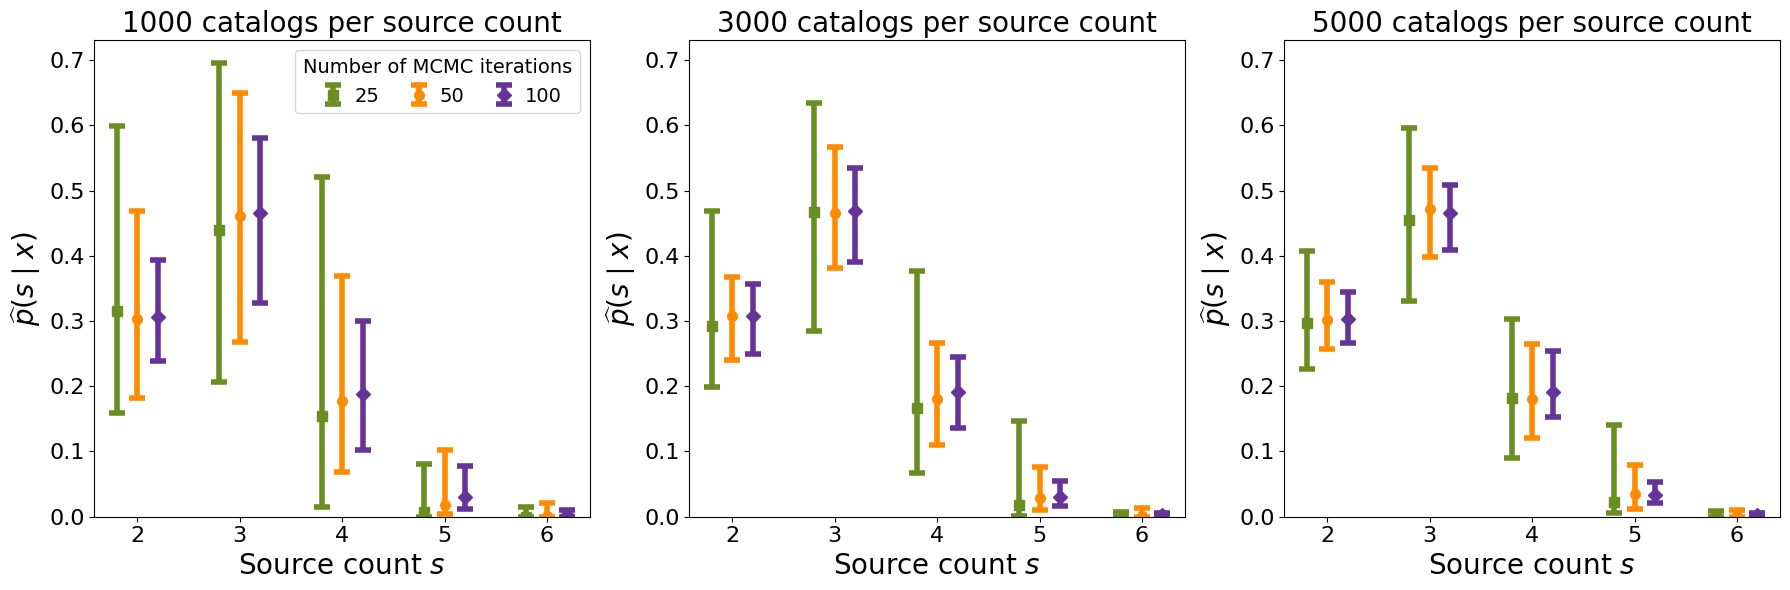

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 0

count_index = countprob_estimate[i,-1,-1].sort().indices[-5:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = countprob_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                y = median,
                                yerr = [median - countprob_lower[i,c,m][count_index].numpy(),
                                        countprob_upper[i,c,m][count_index].numpy() - median],
                                linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                ms = 7, elinewidth = 4, capsize = 6, capthick = 4)
                _ = ax[c].set_ylim(0, 1.05 * countprob_upper[i,...,count_index].max())
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\widehat{p}(s \mid x)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations",
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

fig.savefig('figures/figure2b.png', dpi = 250, transparent = True)

---

### Estimated marginal loglikelihood for the image with six sources

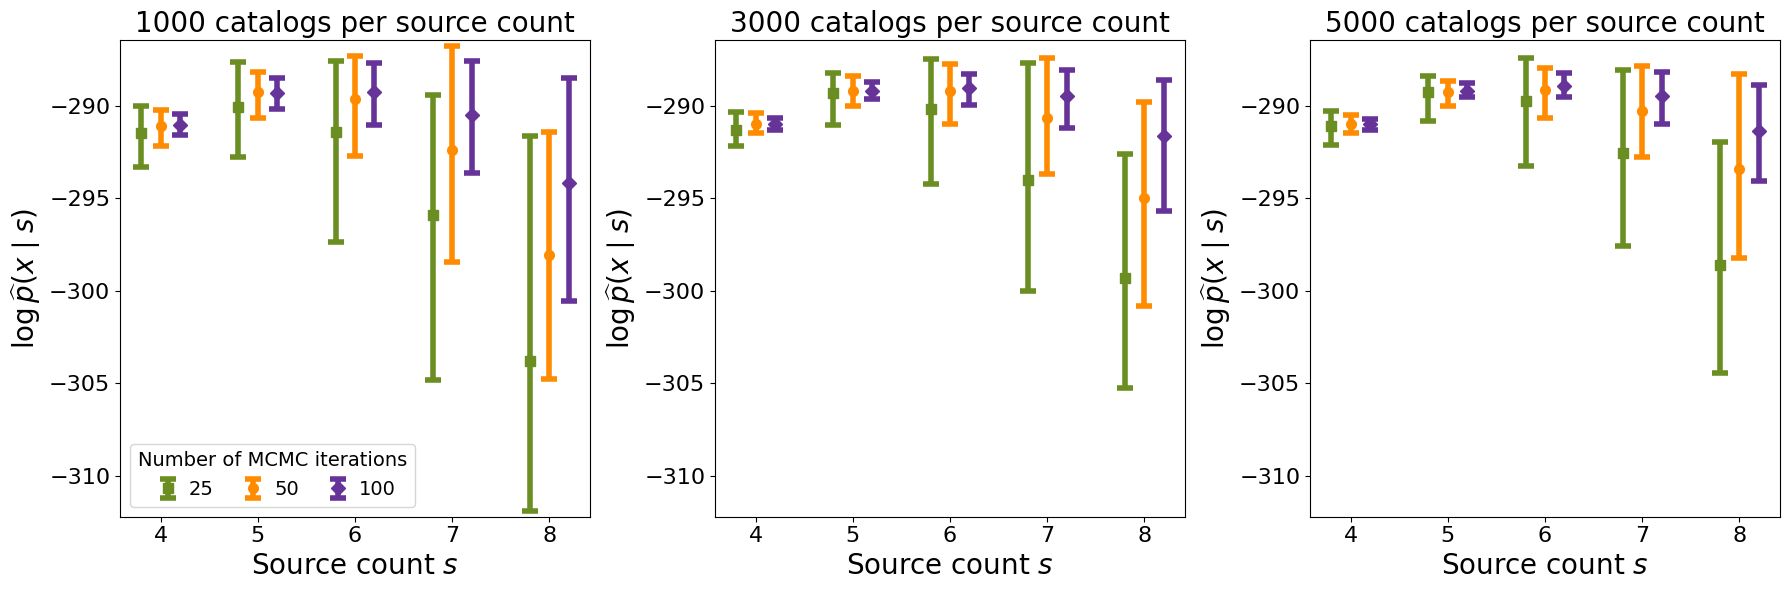

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 1

count_index = log_norm_const_estimate[i,-1,-1].sort().indices[-5:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = log_norm_const_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                   y = median,
                                   yerr = [median - log_norm_const_lower[i,c,m][count_index].numpy(),
                                           log_norm_const_upper[i,c,m][count_index].numpy() - median],
                                   linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                   ms = 7, elinewidth = 4, capsize = 6, capthick = 4)
                _ = ax[c].set_ylim(1.001 * log_norm_const_lower[i,...,count_index].min(),
                                   0.999 * log_norm_const_upper[i,...,count_index].max())
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\log \\widehat{p}(x \mid s)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations",
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

---

### Posterior count probabilities for the image with six sources

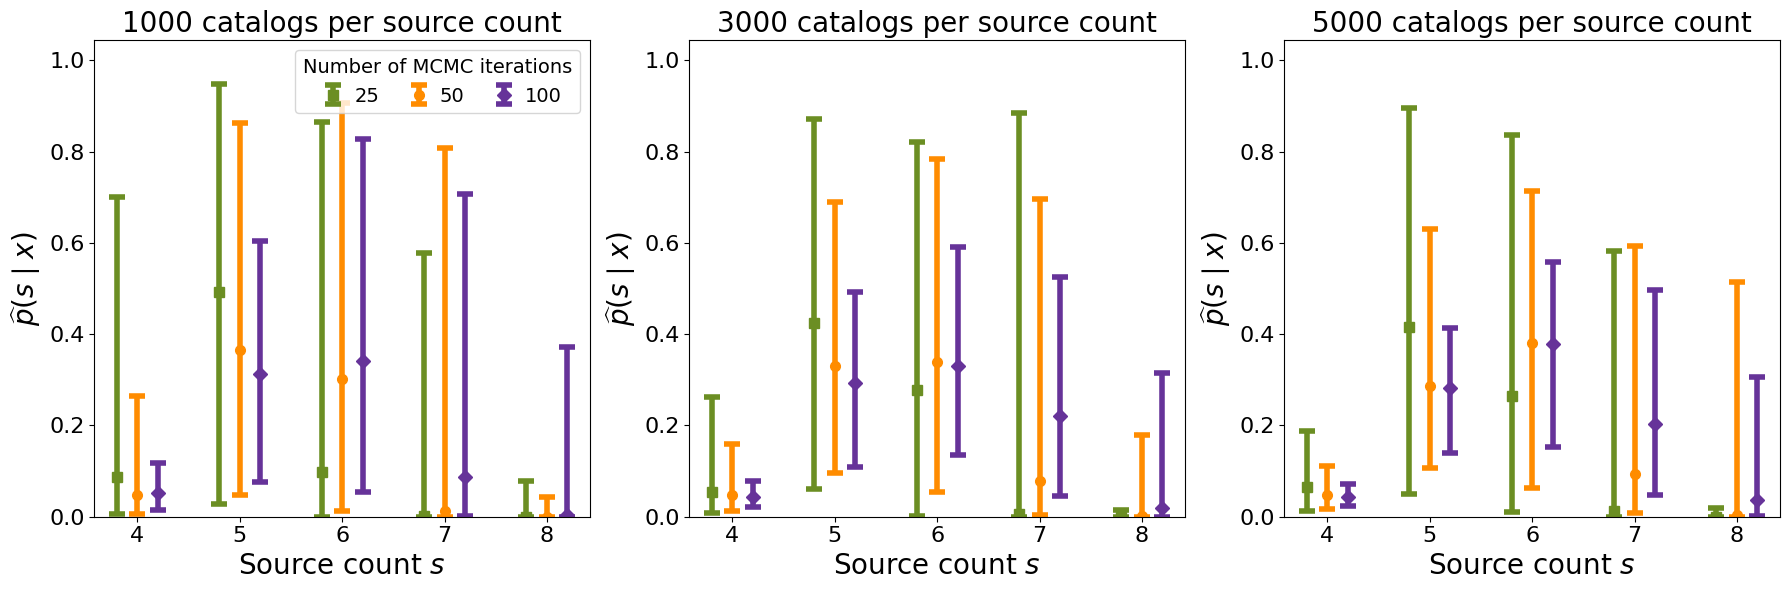

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

i = 1

count_index = countprob_estimate[i,-1,-1].sort().indices[-5:].sort().values

for c in range(len(num_catalogs_per_count)):
        for m in range(len(num_mh_iters)):
                median = countprob_estimate[i,c,m][count_index].numpy()
                _ = ax[c].errorbar(x = count_index + (m - 1) * 0.2,
                                y = median,
                                yerr = [median - countprob_lower[i,c,m][count_index].numpy(),
                                        countprob_upper[i,c,m][count_index].numpy() - median],
                                linestyle = "", color = mh_colors[m], marker = mh_markers[m], label = num_mh_iters[m],
                                ms = 7, elinewidth = 4, capsize = 6, capthick = 4)
                _ = ax[c].set_ylim(0, 1.1 * countprob_upper[i,...,count_index].max())
                _ = ax[c].set_title(f'{num_catalogs_per_count[c]} catalogs per source count', fontsize = bigfont)
                _ = ax[c].set_xlabel('Source count $s$', fontsize = bigfont)
                _ = ax[c].set_ylabel('$\widehat{p}(s \mid x)$', fontsize = bigfont)
                _ = ax[c].tick_params(axis = 'both', labelsize = mediumfont)
                if c == 0:
                        _ = ax[c].legend(title = "Number of MCMC iterations",
                                         ncols = 3, columnspacing = 1, handletextpad = 0.1,
                                         prop = {'size': smallfont}, title_fontsize = smallfont)

fig.tight_layout()

---